In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

import openai
from tenacity import retry, stop_after_attempt, wait_random_exponential

from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
import torch

import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv("Data/gsm8k.csv")
df.head()

,question,answer_text,answer_key,question_arm
0,In Professor Plum's biology class there are 40...,"We start with the initial numbers of students,...",8,Պրոֆեսոր Պլամի կենսաբանության դասարանում սովոր...
1,Diane bought twenty more apples than Cecile. I...,Diane bought 15 + 20 = <<15+20=35>>35 apples.\...,50,Դայան Սեսիլից քսան խնձոր ավելի շատ գնեց։ Եթե ​...
2,Ann can skate 6 miles an hour. Her friend Glen...,First find how far Glenda goes in 3 hours by m...,42,Էննը կարող է սահել ժամում 6 մղոն արագությամբ: ...
3,"Running for 2 hours, Jonah burnt 30 calories e...","When Jonah ran for 2 hours, burning 30 calorie...",90,2 ժամ վազելով՝ Ջոնան ամեն ժամ այրել է 30 կալոր...
4,The city of Richmond has 1000 more people than...,Victoria has 3000-1000=<<3000-1000=2000>>2000 ...,500,"Ռիչմոնդ քաղաքը 1000-ով ավելի մարդ ունի, քան Վի..."


In [3]:
# Read the API key from the file
with open('api_key.txt', 'r') as file:
    api_key = file.read().strip()

# Set the API key in the OpenAI library
openai.api_key = api_key

# Define the model to use
GPT_MODEL = "gpt-3.5-turbo-0613"

In [4]:
@retry(wait=wait_random_exponential(multiplier=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, tools=None, tool_choice=None, model = GPT_MODEL):
    """
    Sends request to the OpenAI API to generate chat completions based on the provided messages.

    Parameters:
    - messages (list): A list of message dictionaries to be sent to the chat completion model.
    - tools (list, optional): A list of tools that can be utilized for generating completions.
    - tool_choice (str, optional): A specific tool choice to influence the completion generation.
    - model (str): The model to be used for generating completions.

    Returns:
    - dict: The JSON response from the API containing the completion if the request is successful.

    Raises:
    - Exception: If the request fails after the maximum number of retry attempts, it raises and
      returns the exception, and prints an error message to the console.
    """
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + openai.api_key,
    }
    json_data = {"model": model, "messages": messages}

    if tools is not None:
        json_data.update({"tools": tools})
    if tool_choice is not None:
        json_data.update({"tool_choice": tool_choice})
        
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
        )
        return response.json() 
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e

# Zero-Shot Prompting

In [16]:
def zero_shot_question(question, language = "English"):
    """
    This function asks a zero-shot question based on the provided question.
    
    Args:
    question (str): The question to ask.
    
    Returns:
    str: The answer generated by the model.
    """
    messages = []
    messages.append({
        "role": "system",
        "content": f"Answer the given question in {language}. Solve the given math problem and give the asnwer in form of the number. Be specific and short."
    })
    messages.append({
        "role": "assistant",
        "content": question
    })
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"] 
    return assistant_message


In [14]:
# Example
question = """Պրոֆեսոր Պլամի կենսաբանության դասարանում սովորում է 40 ուսանող։ Այդ ուսանողների 80 տոկոսն ունի ձագեր: Քոթոթներ ունեցողների 25%-ը նույնպես թութակներ ունի։ Քանի՞ ուսանող ունի և՛ լակոտ, և՛ թութակ:"""
response = zero_shot_question(question, language="Armenian")
print(response)

Առաջինը, ուսանողը լակոտ չէ։
Երկրորդը, ուսանողը թութակ չէ։
Ուսանողների քանակը՝ 40.
Քոթոթներով ուսանողների քանակը՝ 25% * 40 = 10.


In [17]:
def apply_zero_shot_to_df(df, question_col, response_col, language="English"):
    """
    Applies zero-shot question answering to specified question columns of a DataFrame,
    and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - response_col (str): Name of the column where the responses will be stored.
    - language (str, optional): The language in which the questions are provided. Defaults to "English".
    """
    for index, row in df.iterrows():
        response = zero_shot_question(row[question_col], language)
        df.at[index, response_col] = response

    
    # Save the DataFrame after updating
    df.to_csv('Data/gsm8k.csv', index=False)

In [18]:
apply_zero_shot_to_df(df, 'question', 'response_en_ZS')
apply_zero_shot_to_df(df, 'question_arm', 'response_arm_ZS', language='Armenian')

# One-Shot Prompting

In [19]:
def one_shot_question(question, example, language="English"):
    """
    Executes a one-shot learning-based question answering with an example provided.

    Parameters:
    - question (str): The question that needs answering.
    - example (dict): An example containing a question and answer to guide the model.
    - language (str): The language in which the question is written. Defaults to "English".

    Returns:
    - str: The extracted answer if available; otherwise, an error message.
    """
    messages = [
        {"role": "system", "content": f"Answer the given question in {language}. Solve the given math problem and give the asnwer in form of the number. Be specific and short."},
        {"role": "assistant", "content": example["question"]},
        {"role": "assistant", "content": example["answer"]},
        {"role": "assistant", "content": question}
    ]
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"] 
    return assistant_message

In [20]:
def apply_one_shot_to_df(df, question_col, example, response_col, language="English"):
    """
    Applies one-shot question answering to specified columns of a DataFrame,
    using an example to guide the model, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - example (dict): The example to guide the model.
    - response_col (str): Name of the column where the responses will be stored.
    - language (str, optional): The language in which the questions, passages, and examples are provided. Defaults to "English".
    """
    for index, row in df.iterrows():
        response = one_shot_question(row[question_col], example, language)
        df.at[index, response_col] = response

    # Save the DataFrame after updating
    df.to_csv('Data/gsm8k.csv', index=False)


In [22]:
example_en = {
    "question": """There are 50 children at the party. 
    Three-fifths of them are boys. How many of the children are girls?""",
    "answer": """"50 x 3/5 = <<50*3/5=30>>30 children are boys. 
    So, there are 50 - 30 = <<50-30=20>>20 children that are girls.
    Answer: 20 """
}

example_arm = {
    "question" : """Խնջույքին 50 երեխա կա։ Նրանց երեք հինգերորդը տղաներ են։
    Երեխաներից քանիսն են աղջիկներ:""",
    "answer": """50 x 3/5 = <<50*3/5=30>>30 երեխան տղա է։
    Այսպիսով, աղջիկների քանակը կլինի 50 - 30 = <<50-30=20>>20 աղջիկներ։ Պատասխան՝ 20"""
}

In [23]:
apply_one_shot_to_df(df, 'question', example_en, 'response_en_OS')
apply_one_shot_to_df(df, 'question_arm', example_arm, 'response_arm_OS', language = "Armenian")

# Few-Shot Prompting

In [28]:
def few_shot_question(question, few_shot_examples, language="English"):
    """
    Executes a few-shot learning-based question answering with multiple examples provided, without using a passage.

    Parameters:
    - question (str): The question that needs answering.
    - few_shot_examples (list of dicts): A list of examples, each containing a question and an answer to guide the model.
    - language (str): The language in which the questions are written. Defaults to "English".

    Returns:
    - str: The extracted answer if available; otherwise, an error message.
    """
    messages = [
        {"role": "system", "content": f"Answer the given question in {language}. Solve the given math problem and give the asnwer in form of the number. Be specific and short."}
    ]

    # Iterate through all provided examples
    for example in few_shot_examples:
        messages.extend([
            {"role": "assistant", "content": example["question"]},
            {"role": "assistant", "content": example["answer"]}
        ])

    messages.append({"role": "assistant", "content": question})
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"] 
    
    return assistant_message

In [29]:
def apply_few_shot_to_df(df, question_col, few_shot_examples, response_col, language="English"):
    """
    Applies few-shot question answering to specified question column of a DataFrame,
    using a list of examples to guide the model, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - few_shot_examples (list of dicts): A list of examples, each containing a question and answer.
    - response_col (str): Name of the column where the responses will be stored.
    - language (str, optional): The language in which the questions are written. Defaults to "English".

    Returns:
    - pandas.DataFrame: The updated DataFrame with responses added in a new column.
    """
   
    for index, row in df.iterrows():
        response = few_shot_question(row[question_col], few_shot_examples, language)
        df.at[index, response_col] = response

    df.to_csv('Data/gsm8k.csv', index=False)

In [30]:
few_shot_examples_en = [
    {"question": """Vlad is 6 feet, 3 inches tall. His younger sister is 2 feet, 10 inches tall. How many inches taller is Vlad than his sister?""", 
     "answer": """"Vlad = 6 ft * 12 in/ft + 3 = <<6*12+3=75>>75 inches․ Sister = 2 ft * 12 in/ft + 10 = <<2*12+10=34>>34 inches 75 - 34 = <<75-34=41>>41 inches․ Vlad is 41 inches taller than his sister. Answer: 41 """},

    {"question": """James takes 5 oranges and breaks each orange into 8 pieces. He splits the pieces between 4 people. If an orange has 80 calories how many calories does each person get?""", 
     "answer": """"He makes 5*8=<<5*8=40>>40 pieces. So each person gets 40/4=<<40/4=10>>10 pieces. That means each person eats 10/8=<<10/8=1.25>>1.25 of an orange, so each person eats 80*1.25=<<80*1.25=100>>100 calories of orange. Answer: 100 """},

    {"question": """Bob drove for one and a half hours at 60/mph. He then hit construction and drove for 2 hours at 45/mph. How many miles did Bob travel in those 3 and a half hours?""", 
     "answer": """"Bob drove for 1.5 hour * 60/mph = <<1.5*60=90>>90 miles․ Bod drove for 2 hour * 45/mph = <<2*45=90>>90 miles. In total Bob drove 90 + 90 miles = <<90+90=180>>180 miles. Answer: 180 """}
]

few_shot_examples_arm = [
    {"question": """Վլադի հասակը 6 ֆուտ 3 դյույմ Է: Նրա կրտսեր քուրոջ հասակը 2 ֆուտ 10 դյույմ է: Քանի՞ դյույմ է բարձր Վլադը իր քրոջից:""", 
     "answer": """Վլադը = 6 ft * 12 in/ft + 3 = <<6*12+3=75>>75 դյույմ: Քույր = 2 ֆտ * 12 դյույմ/ֆտ + 10 = <<2*12+10=34>>34 դյույմ: 75 - 34 = <<75-34=41>>41 դյույմ։ Վլադը քրոջից բարձր է 41 դյույմով:
     Պատասխան՝ 41"""},

    {"question": """Ջեյմսը վերցնում է 5 նարինջ և յուրաքանչյուր նարինջը բաժանում է 8 կտորի։ Նա կտորները բաժանում է 4 հոգու միջև։ Եթե նարինջն ունի 80 կալորիա, քանի՞ կալորիա է ստանում յուրաքանչյուր մարդ:""", 
     "answer": """Նա բաժանում է 5*8=<<5*8=40>>40 կտորի։ Այսպիսով, յուրաքանչյուր մարդ ստանում է 40/4=<<40/4=10>>10 հատ։ Դա նշանակում է, որ յուրաքանչյուր մարդ ուտում է 10/8=<<10/8=1,25>>1,25 նարինջ, ուստի յուրաքանչյուր մարդ ստանում է 80*1,25=<<80*1,25=100>>100 կալորիա։ 
     Պատասխան՝ 100"""},

    {"question": """Բոբը 1,5 ժամ քշեց 60/մ/ժ արագությամբ: Այնուհետև շինարարության պատճառով նա 2 ժամ քշեց 45/մ/ժ արագությամբ: Քանի՞ մղոն անցավ Բոբը այդ 3,5 ժամում:""", 
     "answer": """Բոբը քշեց 1,5 ժամ * 60/մ/ժ = <<1,5*60=90>>90 մղոն․ Բոդը քշեց 2 ժամ * 45/մ/ժ = <<2*45=90>>90 մղոն։ Ընդհանուր առմամբ Բոբը քշեց 90 + 90 մղոն = <<90+90=180>>180 մղոն։
    Պատասխան՝ 180"""}
]

In [31]:
apply_few_shot_to_df(df, "question", few_shot_examples_en, "response_en_FS")
apply_few_shot_to_df(df, 'question_arm', few_shot_examples_arm, 'response_arm_FS', language = "Armenian")

# Using Armenian as the language of system_message

## Zero-Shot

In [33]:
def zero_shot_question_arm(question):
    """
    This function asks a zero-shot question based on the provided question.
    
    Args:
    question (str): The question to ask.
    
    Returns:
    str: The answer generated by the model.
    """
    messages = []
    messages.append({
        "role": "system",
        "content": "Լուծիր տրված մաթեմատիկական խնդիրները և տուր պատասխանը թվի տեսքով։ Եղիր կոնկրետ և կարճ"
    })
    messages.append({
        "role": "assistant",
        "content": question
    })
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"] 
    return assistant_message

In [34]:
def apply_zero_shot_to_df_arm(df, question_col, response_col):
    """
    Applies zero-shot question answering to specified question columns of a DataFrame,
    and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - response_col (str): Name of the column where the responses will be stored.
    - language (str, optional): The language in which the questions are provided. Defaults to "English".
    """
    for index, row in df.iterrows():
        response = zero_shot_question_arm(row[question_col])
        df.at[index, response_col] = response

    
    # Save the DataFrame after updating
    df.to_csv('Data/gsm8k.csv', index=False)

In [35]:
apply_zero_shot_to_df_arm(df, 'question_arm', 'response_arm_sys_ZS')

## One-Shot

In [36]:
def one_shot_question_arm(question, example):
    """
    Executes a one-shot learning-based question answering with an example provided.

    Parameters:
    - question (str): The question that needs answering.
    - example (dict): An example containing a question and answer to guide the model.
    - language (str): The language in which the question is written. Defaults to "English".

    Returns:
    - str: The extracted answer if available; otherwise, an error message.
    """
    messages = [
        {"role": "system", "content": "Լուծիր տրված մաթեմատիկական խնդիրները և տուր պատասխանը թվի տեսքով։ Եղիր կոնկրետ և կարճ:"},
        {"role": "assistant", "content": example["question"]},
        {"role": "assistant", "content": example["answer"]},
        {"role": "assistant", "content": question}
    ]
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"] 
    return assistant_message

In [37]:
def apply_one_shot_to_df_arm(df, question_col, example, response_col):
    """
    Applies one-shot question answering to specified columns of a DataFrame,
    using an example to guide the model, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - example (dict): The example to guide the model.
    - response_col (str): Name of the column where the responses will be stored.
    - language (str, optional): The language in which the questions, passages, and examples are provided. Defaults to "English".
    """
    for index, row in df.iterrows():
        response = one_shot_question_arm(row[question_col], example)
        df.at[index, response_col] = response

    # Save the DataFrame after updating
    df.to_csv('Data/gsm8k.csv', index=False)


In [38]:
apply_one_shot_to_df_arm(df, 'question_arm', example_arm, 'response_arm_sys_OS')

## Few-Shot

In [39]:
def few_shot_question_arm(question, few_shot_examples):
    """
    Executes a few-shot learning-based question answering with multiple examples provided, without using a passage.

    Parameters:
    - question (str): The question that needs answering.
    - few_shot_examples (list of dicts): A list of examples, each containing a question and an answer to guide the model.
    - language (str): The language in which the questions are written. Defaults to "English".

    Returns:
    - str: The extracted answer if available; otherwise, an error message.
    """
    messages = [
        {"role": "system", "content": "Լուծիր տրված մաթեմատիկական խնդիրները և տուր պատասխանը թվի տեսքով։ Եղիր կոնկրետ և կարճ:"}
    ]

    # Iterate through all provided examples
    for example in few_shot_examples:
        messages.extend([
            {"role": "assistant", "content": example["question"]},
            {"role": "assistant", "content": example["answer"]}
        ])

    messages.append({"role": "assistant", "content": question})
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"] 
    
    return assistant_message

In [40]:
def apply_few_shot_to_df_arm(df, question_col, few_shot_examples, response_col):
    """
    Applies few-shot question answering to specified question column of a DataFrame,
    using a list of examples to guide the model, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - few_shot_examples (list of dicts): A list of examples, each containing a question and answer.
    - response_col (str): Name of the column where the responses will be stored.
    - language (str, optional): The language in which the questions are written. Defaults to "English".

    Returns:
    - pandas.DataFrame: The updated DataFrame with responses added in a new column.
    """
   
    for index, row in df.iterrows():
        response = few_shot_question_arm(row[question_col], few_shot_examples)
        df.at[index, response_col] = response

    df.to_csv('Data/gsm8k.csv', index=False)

In [41]:
apply_few_shot_to_df_arm(df, 'question_arm', few_shot_examples_arm, 'response_arm_sys_FS')

# Calculating Setence Similarity Using BERT

In [42]:
# Back-translated data using google sheets =GOOGLETRANSLATE() function
# df = pd.read_csv("Data/gsm8k.csv")

In [50]:
def calculate_bert_similarity(sentence1, sentence2, tokenizer, model, device):
    """
    Calculate the cosine similarity between two sentences using BERT embeddings.

    Parameters:
    - sentence1 (str): The first sentence.
    - sentence2 (str): The second sentence.

    Returns:
    - float: The cosine similarity score between the two sentence embeddings.
    """
    # Tokenize the sentences
    encodings = tokenizer(
        [sentence1, sentence2], 
        padding=True, 
        return_tensors='pt',
        max_length =512,
        truncation = True
    ).to(device)

    # Generate embeddings with no gradient calculations
    with torch.no_grad():
        outputs = model(**encodings)
        embeddings = outputs.last_hidden_state[:, 0, :]

    # Normalize the embeddings
    normalized_embeddings = F.normalize(embeddings, p=2, dim=1)

    # Compute cosine similarity as dot product of normalized embeddings
    similarity = (normalized_embeddings[0] * normalized_embeddings[1]).sum().item() 
    return similarity

In [44]:
def apply_bert_similarity(df, col1, col2, new_col_name):
    """
    Apply BERT-based similarity calculation for two columns in a DataFrame and add results to a new column.

    Parameters:
    - df (DataFrame): The DataFrame containing the text columns.
    - col1 (str): Column name for the first set of sentences.
    - col2 (str): Column name for the second set of sentences.
    - new_col_name (str): Column name for the similarity scores.
    """
    # Load the BERT model and tokenizer
    bert_version = 'bert-large-uncased'
    tokenizer = BertTokenizer.from_pretrained(bert_version)
    model = BertModel.from_pretrained(bert_version)
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Calculate similarities and add to DataFrame
    df[new_col_name] = df.apply(lambda row: calculate_bert_similarity(row[col1], row[col2], tokenizer, model, device), axis=1)

In [46]:
apply_bert_similarity(df, 'response_en_ZS', 'response_arm_ZS_BT', "sim_response_ZS")
apply_bert_similarity(df, 'response_en_OS', 'response_arm_OS_BT', "sim_response_OS")
apply_bert_similarity(df, 'response_en_FS', 'response_arm_FS_BT', "sim_response_FS")

In [51]:
apply_bert_similarity(df, 'response_en_ZS', 'response_arm_sys_ZS_BT', "sim_response_arm_sys_ZS")
apply_bert_similarity(df, 'response_en_OS', 'response_arm_sys_OS_BT', "sim_response_arm_sys_OS")
apply_bert_similarity(df, 'response_en_FS', 'response_arm_sys_FS_BT', "sim_response_arm_sys_FS")

In [54]:
apply_bert_similarity(df, 'response_en_ZS', 'answer_text', "sim_response_en_reference_ZS")
apply_bert_similarity(df, 'response_en_OS', 'answer_text', "sim_response_en_reference_OS")
apply_bert_similarity(df, 'response_en_FS', 'answer_text', "sim_response_en_reference_FS")
apply_bert_similarity(df, 'response_arm_ZS_BT', 'answer_text', "sim_response_arm_reference_ZS")
apply_bert_similarity(df, 'response_arm_OS_BT', 'answer_text', "sim_response_arm_reference_OS")
apply_bert_similarity(df, 'response_arm_FS_BT', 'answer_text', "sim_response_arm_reference_FS")

In [ ]:
df.to_csv("Data/gsm8k.csv")

# Similarity Statistics

In [55]:
english_responses = ['sim_response_ZS', 'sim_response_OS', 'sim_response_FS']
armenian_sys_language = ['sim_response_arm_sys_ZS', 'sim_response_arm_sys_OS', 'sim_response_arm_sys_FS']
reference_based = ['sim_response_en_reference_ZS', 'sim_response_en_reference_OS', 'sim_response_en_reference_FS',
                   'sim_response_arm_reference_ZS', 'sim_response_arm_reference_OS', 'sim_response_arm_reference_FS']

# Generate descriptive statistics
english_stats = df[english_responses].describe()
armenian_sys_stats = df[armenian_sys_language].describe()
reference_based_stats = df[reference_based].describe()

# Print the statistics to review them
print("English-Armenian Similarity Statistics:")
print(english_stats)
print("\nEnglish-Armenian Similarity Statistics (Sys lang Arm):")
print(armenian_sys_stats)
print("\nReference-Based Responses Statistics:")
print(reference_based_stats)

English-Armenian Similarity Statistics:
       sim_response_ZS  sim_response_OS  sim_response_FS
count        50.000000        50.000000        50.000000
mean          0.603301         0.813526         0.861627
std           0.251445         0.153629         0.087617
min           0.081678         0.260318         0.504701
25%           0.331526         0.768736         0.835523
50%           0.636428         0.862230         0.883544
75%           0.819333         0.911136         0.915751
max           0.984694         0.967692         0.962950

English-Armenian Similarity Statistics (Sys lang Arm):
       sim_response_arm_sys_ZS  sim_response_arm_sys_OS  \
count                50.000000                50.000000   
mean                  0.647247                 0.841597   
std                   0.139051                 0.100389   
min                   0.241012                 0.488324   
25%                   0.540590                 0.830151   
50%                   0.679853       

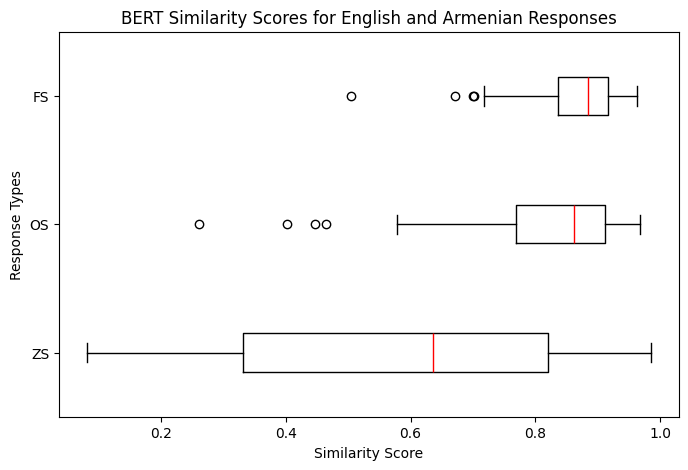

In [57]:
plt.figure(figsize=(8, 5))
plt.boxplot([df['sim_response_ZS'], df['sim_response_OS'], df['sim_response_FS']],
            labels=['ZS', 'OS', 'FS'], vert=False,
            medianprops=dict(color='red')) 
plt.title('BERT Similarity Scores for English and Armenian Responses')
plt.xlabel('Similarity Score')
plt.ylabel('Response Types')
plt.savefig('bert_score_gsm8k_1.png')
plt.show()

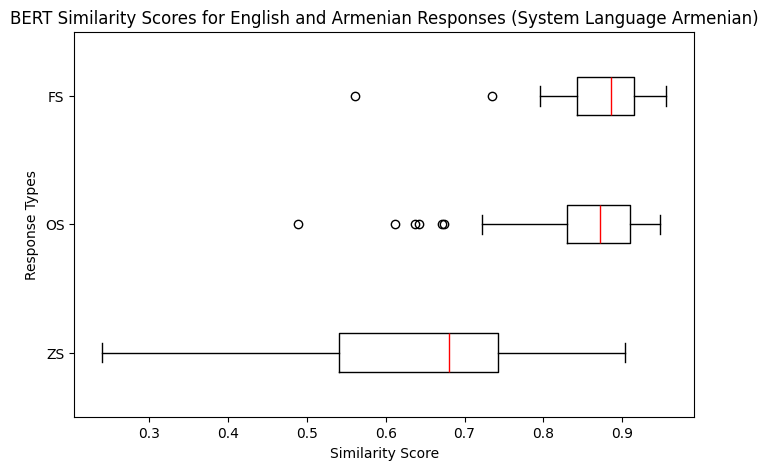

In [58]:
plt.figure(figsize=(8, 5))
plt.boxplot([df['sim_response_arm_sys_ZS'], df['sim_response_arm_sys_OS'], df['sim_response_arm_sys_FS']],
            labels=['ZS', 'OS', 'FS'], vert=False,
            medianprops=dict(color='red')) 
plt.title('BERT Similarity Scores for English and Armenian Responses (System Language Armenian)')
plt.xlabel('Similarity Score')
plt.ylabel('Response Types')
plt.savefig('bert_score_gsm8k_2.png')
plt.show()

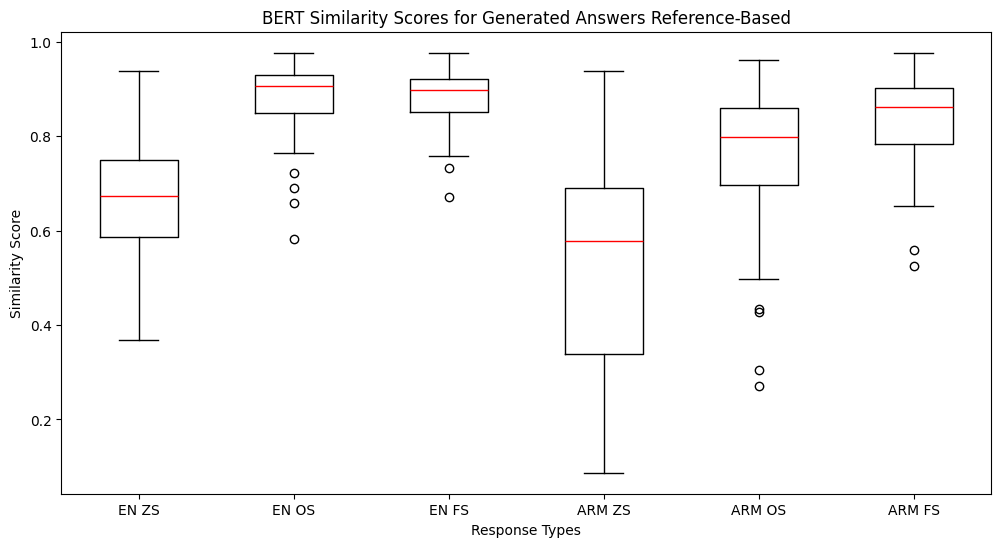

In [60]:
plt.figure(figsize=(12, 6))
plt.boxplot([df['sim_response_en_reference_ZS'],
    df['sim_response_en_reference_OS'],
    df['sim_response_en_reference_FS'],
    df['sim_response_arm_reference_ZS'],
    df['sim_response_arm_reference_OS'],
    df['sim_response_arm_reference_FS']], 
    labels=['EN ZS', 'EN OS', 'EN FS', 'ARM ZS', 'ARM OS', 'ARM FS'],
    vert=True,
    medianprops=dict(color='red')  
)

plt.title('BERT Similarity Scores for Generated Answers Reference-Based')
plt.xlabel('Response Types')
plt.ylabel('Similarity Score')
plt.savefig('bert_score_gsm8k_3.png')
plt.show()
